In [1]:
import numpy as np
import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt
import sklearn
import sklearn.metrics
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import log_loss
from sklearn.model_selection import KFold
import lightgbm as lgb
import nltk
from bs4 import BeautifulSoup
import transformers

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

In [2]:
train = pd.read_csv('data/train.csv')
test = pd.read_csv('data/test.csv')
sub = pd.read_csv('data/sample_submit.csv')
all_preprocessed = pd.read_csv('data/all_region_added_encoded_shortvectorized.csv')

In [3]:
all_preprocessed.head()

,id,goal,country,duration,category1,category2,html_content,state,data_type,region,...,40,41,42,43,44,45,46,47,48,49
0,0,4001-5000,4,28,12,143,"<div class=""contents""><div><span class=""bold"">...",0.0,train,2,...,-0.094082,-0.116380,0.73398,0.159810,0.261700,-0.39400,-1.77100,-1.43360,-0.64829,-0.82776
1,1,3001-4000,16,33,5,108,"<div class=""contents""><div><h1 class=""page-anc...",0.0,train,2,...,0.168950,0.001122,-0.74510,-0.140370,1.125900,-1.11870,-0.78684,-1.28740,-0.84603,-0.25663
2,2,19001-20000,21,29,7,122,"<div class=""contents""><div><p> As our society ...",0.0,train,0,...,-0.443040,1.350800,-1.01760,0.069551,0.023407,-0.21827,-0.57156,-0.74594,0.26706,0.96434
3,3,2001-3000,21,40,13,0,"<div class=""contents""><div><p>My name is Donal...",0.0,train,0,...,-0.307910,-0.008201,0.77016,1.286500,0.090809,-0.30148,-1.46490,-0.86859,-0.32630,-0.71399
4,4,2001-3000,9,28,13,33,"<div class=""contents""><div><div class=""templat...",1.0,train,2,...,-0.307910,-0.008201,0.77016,1.286500,0.090809,-0.30148,-1.46490,-0.86859,-0.32630,-0.71399


In [53]:
def bs_get_text(html):
    return BeautifulSoup(html).get_text()


def count_number_of_figure(html_text):
    count_fig = html_text.count("<figure>")
    """
    count_fig_end = html_text.count("</figure>")
    if not count_fig == count_fig_end:
        return None
    """
    return count_fig


def count_number_of_video(html_text):
    #count_fig = html_text.count("<video>")
    count_video_end = html_text.count("</video>")
    #if not count_fig == count_fig_end:
     #   return None
    return count_video_end


def extract_each_paragraphs(html_text):
    paragraphs = []
    para_list = html_text.split("<p>")
    if not "<p>" in html_text[0:4]:
        para_list = para_list[1:]
    for para in para_list:
        if "</p>" in para:
            para_new = para.split("</p>")[0]
        else:
            para_new = ""
            
        #それでも残っているhtmlタグを取り除く(要らないかも)
        para_new = BeautifulSoup(para_new).get_text()
        #para_new = remove_nobreak_space(para_new)
        
        paragraphs.append(para_new)
    try:
        paragraphs.remove("")
    except:
        pass
    try:
        paragraphs.remove(" ")
    except:
        pass
    try:
        paragraphs.remove(u"\xa0")
    except:
        pass
    
    return paragraphs


def count_number_of_paragraph(html_text):
    paras = extract_each_paragraphs(html_text)
    return len(paras)


from transformers import BertTokenizer, BertForSequenceClassification
bert_tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")
def count_number_of_words(html_text):
    text = bs_get_text(html_text)
    token = bert_tokenizer.encode_plus(
                            text,                       # Sentence to encode.
                            add_special_tokens = True,  # Add '[CLS]' and '[SEP]'
                            max_length = None,  # Pad & truncate all sentences.
                            pad_to_max_length = True,
                            return_attention_mask = True,  # Construct attn. masks.
                       )
    ids = token['input_ids']
    return len(ids)
    
    
def add_html_raw(df_origin):
    df = df_origin.copy()
    df["html_raw"] = list(map(bs_get_text, df["html_content"]))
    return df


def add_n_figure(df_origin):
    df = df_origin.copy()
    df["number_of_figure"] = list(map(count_number_of_figure, df["html_content"]))
    return df


def add_n_video(df_origin):
    df = df_origin.copy()
    df["number_of_video"] = list(map(count_number_of_video, df["html_content"]))
    return df


def add_n_paragraph(df_origin):
    df = df_origin.copy()
    df["number_of_paragraph"] = list(map(count_number_of_paragraph, df["html_content"]))
    return df

def add_n_words(df_origin):
    df = df_origin.copy()
    df["length_of_text"] = list(map(count_number_of_words, df["html_content"]))
    return df

In [54]:
def is_video_exist(n_video):
    is_video_exist = 1 if n_video != 0 else 0
    return is_video_exist

def improve_n_video(df_origin):
    df = df_origin.copy()
    df["video"] = list(map(is_video_exist, df["number_of_video"]))
    return df

In [55]:
def select_paragraphs(para_lis):
    para_len_lis = []
    for para in para_lis:
        n_word = count_number_of_words(para)
        para_len_lis.append(n_word)
    length = sum(para_len_lis)
    while length > 512:
        para_len_lis = para_len_lis[1:]
        length = sum(para_len_lis)
    n_paragraph = len(para_len_lis)
    selected_para = para_lis[-n_paragraph:]
    return selected_para

def choose_para(html):
    para_list = extract_each_paragraphs(html)
    selected_para_list = select_paragraphs(para_list)
    sentence = " ".join(selected_para_list)
    return sentence

def add_each_paragraphs(df_origin):
    df = df_origin.copy()
    df["selected_paragraphs"] = list(map(choose_para, df["html_content"]))
    return df

In [ ]:
def number_of_word_per_sentence():
    

In [56]:
all_new = add_html_raw(all_preprocessed)
all_new = add_n_figure(all_new)
all_new = add_n_video(all_new)
all_new = add_n_paragraph(all_new)
all_new = add_n_words(all_new)
all_new = improve_n_video(all_new)
all_new = add_each_paragraphs(all_new)
all_new.to_csv('data/all_df_nlp_preprocessed.csv', index=False)
all_new.head()

/Applications/anaconda3/lib/python3.8/site-packages/bs4/__init__.py:329: MarkupResemblesLocatorWarning: "." looks like a filename, not markup. You should probably open this file and pass the filehandle into Beautiful Soup.
  warnings.warn(
/Applications/anaconda3/lib/python3.8/site-packages/bs4/__init__.py:414: MarkupResemblesLocatorWarning: "http://dummy.com" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to get the document behind the URL, and feed that document to Beautiful Soup.
  warnings.warn(
/Applications/anaconda3/lib/python3.8/site-packages/bs4/__init__.py:329: MarkupResemblesLocatorWarning: "//////////////////////////////////////////////////////////////////////////////////////////////////////////////////////" looks like a filename, not markup. You should probably open this file and pass the filehandle into Beautiful Soup.
  warnings.warn(
/Applications/anaconda3/lib/python3.8/site-packages/bs4/__init__.py:329: Mar

,id,goal,country,duration,category1,category2,html_content,state,data_type,region,...,47,48,49,html_raw,number_of_figure,number_of_video,number_of_paragraph,length_of_text,video,selected_paragraphs
0,0,4001-5000,4,28,12,143,"<div class=""contents""><div><span class=""bold"">...",0.0,train,2,...,-1.43360,-0.64829,-0.82776,Mark Saggia is an Italian writer who emigrated...,6,0,42,1297,0,Some pictures about the italian book presentat...
1,1,3001-4000,16,33,5,108,"<div class=""contents""><div><h1 class=""page-anc...",0.0,train,2,...,-1.28740,-0.84603,-0.25663,"Hello, I am Augustinas. I am a graphic designe...",15,0,4,235,0,I think that street fashion is not haute coutu...
2,2,19001-20000,21,29,7,122,"<div class=""contents""><div><p> As our society ...",0.0,train,0,...,-0.74594,0.26706,0.96434,As our society begins to wake up from the han...,4,1,6,679,1,Our website: www.hnuqiponics.com Have you ever...
3,3,2001-3000,21,40,13,0,"<div class=""contents""><div><p>My name is Donal...",0.0,train,0,...,-0.86859,-0.32630,-0.71399,My name is Donald Osborne and I am an entrepre...,0,0,1,339,0,My name is Donald Osborne and I am an entrepre...
4,4,2001-3000,9,28,13,33,"<div class=""contents""><div><div class=""templat...",1.0,train,2,...,-0.86859,-0.32630,-0.71399,"\n\n\n\n\nWe all love to play, don't we! No ma...",58,9,44,1956,1,Learn the robotics basics using the love of th...


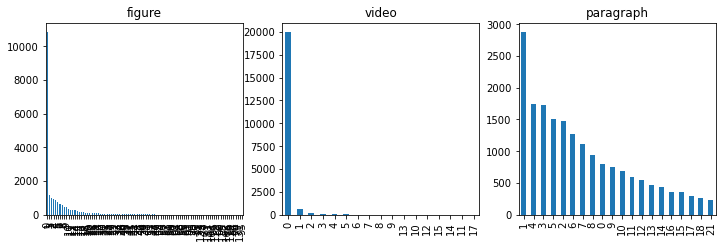

In [25]:
plt.figure(figsize=(12,12))

plt.subplot(3,3,1)
plt.title('figure')
all_new.number_of_figure.value_counts().plot(kind='bar')

plt.subplot(3,3,2)
plt.title('video')
all_new.number_of_video.value_counts().plot(kind='bar')

plt.subplot(3,3,3)
plt.title('paragraph')
all_new.number_of_paragraph.value_counts()[:20].plot(kind='bar')

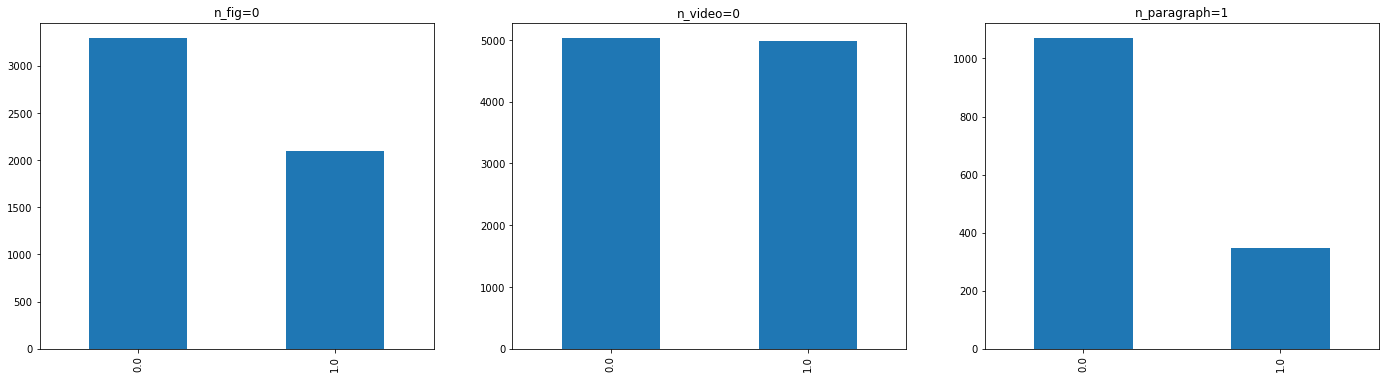

In [30]:
plt.figure(figsize=(24,6))

plt.subplot(1,3,1)
plt.title("n_fig=0")
all_new[all_new["number_of_figure"] == 0]["state"].value_counts().plot(kind="bar")

plt.subplot(1,3,2)
plt.title("n_video=0")
all_new[all_new["number_of_video"] == 0]["state"].value_counts().plot(kind="bar")

plt.subplot(1,3,3)
plt.title("n_paragraph=1")
all_new[all_new["number_of_paragraph"] == 1]["state"].value_counts().plot(kind="bar")

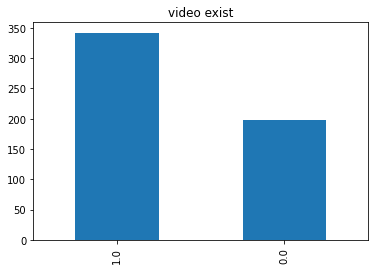

In [40]:
plt.figure()
plt.title("video exist")
all_new[all_new["video"] == 1]["state"].value_counts().plot(kind="bar")

In [6]:
html = all_preprocessed.html_content[0]

In [27]:
def extract_html_tag(html_text):
    tag = re.findall(r"<.*?>", html_text)
    tag_set = set(tag)
    return tag_set

In [28]:
tags = extract_html_tag(html)
tags

{'</div>',
 '</figure>',
 '</p>',
 '</span>',
 '<a href="http://dummy.com" to a large one, who wouldn\'t have respect for his ideas.\xa0</p>',
 '<div class="contents">',
 '<div class="template asset" contenteditable="false" data-alt-text="" data-caption="" data-id="_xxx_">',
 '<div>',
 '<figure>',
 '<img alt="" class="fit lazyload" data-src="http://dummy.com"/>',
 '<p>',
 '<span class="bold">'}

In [30]:
tags = set()
for n, html_text in tqdm(enumerate(all_preprocessed.html_content)):
    tags |= extract_html_tag(html_text)


21089it [00:01, 13552.99it/s]
IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)

